# <center>Лекція 7. Пониження розмірності та кластеризація</center>

<a class="anchor" id="7"></a>

## Зміст

- [7.1. Метод головних компонент (PCA)](#7.1)
    + [7.1.1. Інтуїція, теорія та особливості застосування](#7.1.1)
    + [7.1.2. Приклад використання PCA за набором даних квіток ірису](#7.1.2)
    + [7.1.3. Метод головних компонент: іграшковий приклад](#7.1.3)
- [7.2. Методи кластерного аналізу](#7.2)
    + [7.2.1. $k$-середніх](#7.2.1)
    + [7.2.2. Поширення спорідненості](#7.2.2)
    + [7.2.3. Ієрархічна кластеризація](#7.2.3)
    + [7.2.4. Метрики якості кластеризації](#7.2.4)  
- [7.3. Корисні посилання](#7.3)

Основна відмінність методів навчання без учителя від звичних класифікацій і регресій машинного навчання (МН) в тому, що розмітки для даних в цьому випадку немає. З цього факту випливає відразу кілька особливостей:

- ми можемо використовувати значно більше даних, оскільки їх не потрібно розмічати руками для навчання;
- неочевидно як вимірювати якість застосовуваних методів, оскільки немає таких же прямолінійних та інтуїтивно зрозумілих метрик, як в задачах навчання з учителем.

Очевидно, що відсутність явної розмітки дає змогу виконувати зниження розмірності даних без суттєвих негативних наслідків на цільовий показник. З одного боку зниження розмірності можна розглядати як допомогу у візуалізації даних; наприклад, метод t-SNE, який ми розглянули в другій темі курсу ІАД. З іншого боку таке зниження розмірності може відкинути зайві сильно корельовані ознаки в спостереженнях і підготувати дані для подальшої обробки в режимі навчання з учителем; наприклад, можемо зробити вхідні дані більш "перетравлюваними" для дерев рішень.

<a class="anchor" id="7.1"></a>

## <span style="color:blue; font-size:1.2em;">7.1. Метод головних компонент (PCA)</span>

[Повернутися до змісту](#7)

<a class="anchor" id="7.1.1"></a>

### <span style="color:blue; font-size:1.2em;">7.1.1. Інтуїція, теорія та особливості застосування</span>

[Повернутися до змісту](#7)

Метод головних компонент (з англ. principal component analysis, PCA) – один з найінтуїтивніших і найчастіше використовуваних методів для зниження розмірності даних та проєкції їх на ортогональний підпростір ознак.

<img align="right" src="https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/main/03_img/7_1_pca.png" width="400">

Ідею PCA розуміють як те, що всі емпирічні спостереження швидше за все виглядають як певний еліпсоїд у підпросторі початкового простору і новий базис у цьому просторі збігається з осями цього еліпсоїда. Це припущення дає змогу одночасно позбавитися сильно корельованих ознак, оскільки вектора базису простору, на який відбувається проєктування, будуть ортогональними.

Загалом розмірність цього еліпсоїда дорівнюватиме розмірності початкового простору. Проте припущення про те, що дані лежать у підпросторі меншої розмірності, дає змогу відкинути "зайвий" підпростір у новій проєкції, тобто той підпростір, вздовж осей якого еліпсоїд буде найменш розтягнутим. Виконуватимемо це "жадібно", вибираючи по черзі як новий елемент базису нового підпростору послідовно вісь еліпсоїда з тих, що залишилися, вздовж якої дисперсія буде максимальною.

> (ENG) "To deal with hyper-planes in a 14 dimensional space, visualize a 3D space and say 'fourteen' very loudly. Everyone does it." – Geoffrey Hinton

> (УКР) "Щоб опрацювати гіперплощини в 14-вимірному просторі, візуалізуйте їх у тривимірному просторі і промовте «чотирнадцять» дуже голосно. Усі це роблять." – Джеффрі Хінтон

Розглянемо як це робиться математично:

Щоб знизити розмірність наших даних з $n$ до $k, k \leq n$, нам потрібно вибрати топ-$k$ осей еліпсоїда, що відсортовані за спаданням за дисперсією вздовж осей.

Почнемо з того, що обрахуємо [дисперсії](https://uk.wikipedia.org/wiki/%D0%94%D0%B8%D1%81%D0%BF%D0%B5%D1%80%D1%81%D1%96%D1%8F_%D0%B2%D0%B8%D0%BF%D0%B0%D0%B4%D0%BA%D0%BE%D0%B2%D0%BE%D1%97_%D0%B2%D0%B5%D0%BB%D0%B8%D1%87%D0%B8%D0%BD%D0%B8) та [коваріації](https://uk.wikipedia.org/wiki/%D0%9A%D0%BE%D0%B2%D0%B0%D1%80%D1%96%D0%B0%D1%86%D1%96%D1%8F) початкових ознак. Це робиться просто за допомогою матриці коваріації. За визначенням коваріації, для двох ознак $X_i$ і $X_j$ їхня коваріація дорівнює

$$\large cov(X_i, X_j) = E[(X_i - \mu_i) (X_j - \mu_j)] = E[X_i X_j] - \mu_i \mu_j,$$

де $\mu_i$ – математичне очікування $i$-ої ознаки.

Водночас відзначимо, що коваріація є симетричною і коваріація вектора з самим собою дорівнюватиме його дисперсії.

Отже, матриця коваріації є симетричною матрицею, де на діагоналі лежать дисперсії відповідних ознак, а поза діагоналлю – коваріації відповідних пар ознак. У матричному вигляді, де $\mathbf{X}$ - це матриця спостережень, шукана матриця коваріації виглядатиме так

$$\large \Sigma = E[(\mathbf{X} - E[\mathbf{X}]) (\mathbf{X} - E[\mathbf{X}])^{T}].$$

Матриці з точки зору лінійних операторів мають цікаву властивість, а саме наявність власних значень та власних векторів (eigenvalues та eigenvectors). Ці елементи матриці корисні тим, що коли ми нашою матрицею діємо на відповідний лінійний простір, власні вектори залишаються на місці і лише множаться на відповідні їм власні значення. Тобто ці вектори визначають підпростір, який, у разі застосування цієї матриці як лінійного оператора, залишається на місці або "переходить в себе". Формально власний вектор $w_i$ із власним значенням $\lambda_i$ для матриці $M$ визначається просто як $M w_i = \lambda_i w_i$.

Матрицю коваріації для вибірки $\mathbf{X}$ можна подати у вигляді добутку $\mathbf{X}^{T} \mathbf{X}$. З [відношення Релея](https://uk.wikipedia.org/wiki/%D0%92%D1%96%D0%B4%D0%BD%D0%BE%D1%88%D0%B5%D0%BD%D0%BD%D1%8F_%D0%A0%D0%B5%D0%BB%D0%B5%D1%8F) випливає, що максимальна варіація заданого набору даних буде досягатися вздовж власного вектора цієї матриці, що відповідає максимальному власному значенню. Отже, головні компоненти, на які проєктуються дані, є просто власними векторами відповідних топ-$k$ власних значень цієї матриці.

Подальші кроки досить прості – треба помножити матрицю початкових даних на ці компоненти, і ми отримаємо проєкцію цих даних в ортогональному базисі цих компонентів. Тепер якщо ми транспонуємо матрицю даних та матрицю векторів головних компонент, ми відновимо початкову вибірку у тому просторі, з якого ми робили проєкцію на компоненти. Якщо кількість компонент була меншою за розмірність початкового простору, ми втратимо частину інформації за такого перетворення.

<a class="anchor" id="7.1.2"></a>

### <span style="color:blue; font-size:1.2em;">7.1.2. Приклад використання PCA за набором даних квіток ірису</span>

[Повернутися до змісту](#7)

Опрацювання вправ почнемо з того, що завантажимо всі необхідні модулі та типовий набір даних з ірисами за прикладом документації пакету scikit-learn.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Задамо графіки у форматі .svg, щоби вони мали кращу чіткість
%config InlineBackend.figure_format = 'svg' 

# Підвищимо розмір графіків за замовчуванням
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 7, 5
plt.rcParams['axes.grid'] = True

%matplotlib inline
from sklearn import decomposition
from sklearn import datasets
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Завантажимо наші іриски
iris = datasets.load_iris()
X = iris.data
y = iris.target

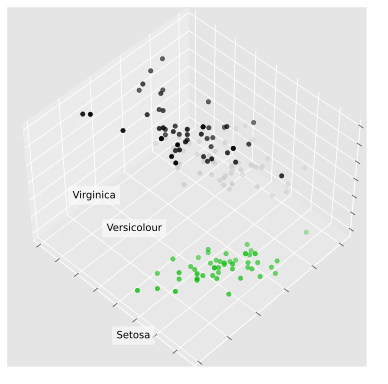

In [3]:
# Подамо набір даних у вигляді тривимірного графіку
fig = plt.figure(1, figsize=(6, 5))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134, auto_add_to_figure=False)
fig.add_axes(ax)

plt.cla()

for name, label in [('Setosa', 0), ('Versicolour', 1), ('Virginica', 2)]:
    ax.text3D(X[y == label, 0].mean(),
              X[y == label, 1].mean() + 1.5,
              X[y == label, 2].mean(), name,
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
    
# Поміняємо порядок кольорів міток, щоб вони відповідали правильному
y_clr = np.choose(y, [1, 2, 0]).astype(float)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y_clr, cmap=plt.cm.nipy_spectral)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([]);

Тепер глянемо, як PCA покращить результати моделі, що погано справляється із класифікацією через те, що у неї не вистачить складності для опису даних:

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

# Виділимо з наших даних тестову вибірку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, 
                                                    stratify=y, 
                                                    random_state=42)

# Для прикладу візьмемо неглибоке дерево рішень
clf = DecisionTreeClassifier(max_depth=2, random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_test)
print('Accuracy: {:.3f}'.format(accuracy_score(y_test, 
                                                preds.argmax(axis=1))))

Accuracy: 0.889


Тепер спробуємо зробити те саме, але з даними, для яких ми знизили розмірність до 2D:

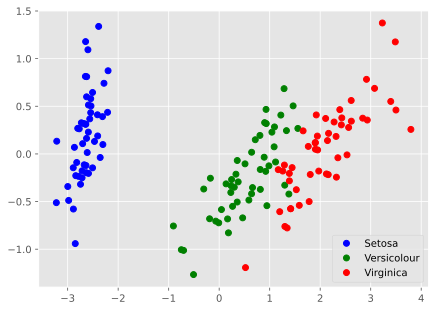

In [5]:
# Використаємо вбудований в sklearn PCA
pca = decomposition.PCA(n_components=2)
X_centered = X - X.mean(axis=0)
pca.fit(X_centered)
X_pca = pca.transform(X_centered)

# Зобразимо точки в новому просторі.
plt.plot(X_pca[y == 0, 0], X_pca[y == 0, 1], 'bo', label='Setosa')
plt.plot(X_pca[y == 1, 0], X_pca[y == 1, 1], 'go', label='Versicolour')
plt.plot(X_pca[y == 2, 0], X_pca[y == 2, 1], 'ro', label='Virginica')
plt.legend(loc=0);

In [6]:
# Повторимо те саме розбиття для валідаційного та тестових наборів даних
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=.3, 
                                                    stratify=y, 
                                                    random_state=42)

clf = DecisionTreeClassifier(max_depth=2, random_state=42)
clf.fit(X_train_pca, y_train_pca)
preds = clf.predict_proba(X_test_pca)
print('Accuracy: {:.3f}'.format(accuracy_score(y_test_pca, 
                                                preds.argmax(axis=1))))

Accuracy: 0.911


Бачимо, що точність трохи підвищилася (0.911 > 0.888). Проте для складніших даних вищої розмірності, де дані не розбиваються тривіально вздовж однієї ознаки, застосування PCA може суттєво покращити якість роботи дерев рішень та ансамблів на їхній основі.

Подивимося на 2 головні компоненти в останньому PCA-поданні даних і на той відсоток початкової дисперсії в даних, який вони "пояснюють".

In [7]:
for i, component in enumerate(pca.components_):
    print("{} component: {}% of initial variance".format(i + 1, 
          round(100 * pca.explained_variance_ratio_[i], 2)))
    print(" + ".join("%.3f x %s" % (value, name)
                     for value, name in zip(component,
                                            iris.feature_names)))

1 component: 92.46% of initial variance
0.361 x sepal length (cm) + -0.085 x sepal width (cm) + 0.857 x petal length (cm) + 0.358 x petal width (cm)
2 component: 5.31% of initial variance
0.657 x sepal length (cm) + 0.730 x sepal width (cm) + -0.173 x petal length (cm) + -0.075 x petal width (cm)


#### Набір даних за рукописними цифрами

Тепер візьмемо набір даних за рукописними цифрами. Ми з ним уже працювали в попередній лекції про дерева рішень і метод найближчих сусідів.

In [8]:
digits = datasets.load_digits()
X = digits.data
y = digits.target

Згадаймо, як ці цифри виглядають – подивимося на перші десять з них. Зображення тут є матрицями 8 x 8 (інтенсивності білого кольору для кожного пікселя). Далі ця матриця "розгортається" у вектор довжиною 64; отримуємо так званий ознаковий опис об'єкта.

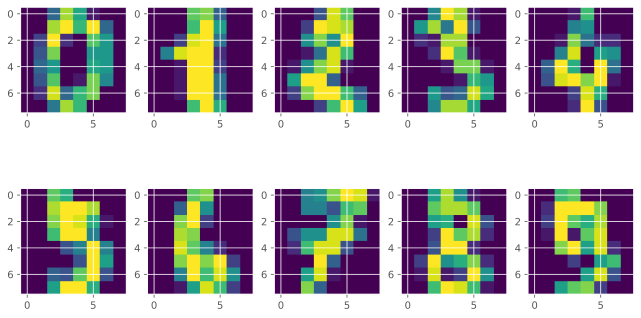

In [9]:
plt.figure(figsize=(11, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[i,:].reshape([8,8]));

Отримуємо розмірність ознакового простору тут – 64. Знизимо розмірність всього до 2 і побачимо, що навіть на око рукописні цифри непогано розділяються на кластери.

Projecting 64-dimensional data to 2D


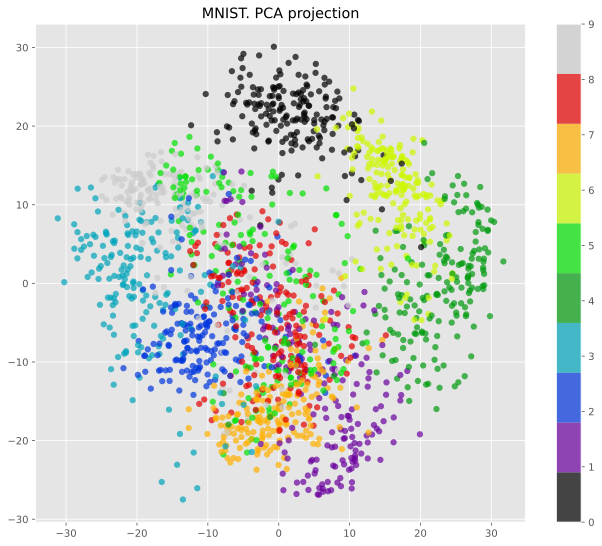

In [10]:
pca = decomposition.PCA(n_components=2)
X_reduced = pca.fit_transform(X)

print('Projecting %d-dimensional data to 2D' % X.shape[1])

plt.figure(figsize=(11,9))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('MNIST. PCA projection');

З методом [t-SNE](https://uk.wikipedia.org/wiki/T-%D1%80%D0%BE%D0%B7%D0%BF%D0%BE%D0%B4%D1%96%D0%BB%D0%B5%D0%BD%D0%B5_%D0%B2%D0%BA%D0%BB%D0%B0%D0%B4%D0%B5%D0%BD%D0%BD%D1%8F_%D1%81%D1%82%D0%BE%D1%85%D0%B0%D1%81%D1%82%D0%B8%D1%87%D0%BD%D0%BE%D1%97_%D0%B1%D0%BB%D0%B8%D0%B7%D1%8C%D0%BA%D0%BE%D1%81%D1%82%D1%96) розбиття виходить ще кращим, оскільки PCA має обмеження – він знаходить тільки лінійні комбінації початкових ознак. Зате навіть у цьому відносно невеликому наборі даних можна побачити, наскільки довше працює t-SNE.

C:\Users\radiu\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


CPU times: total: 1min 31s
Wall time: 21 s


Text(0.5, 1.0, 'MNIST. t-SNE projection')

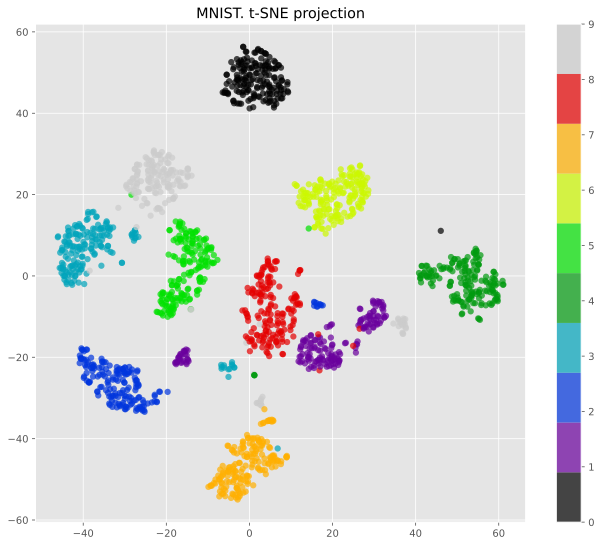

In [11]:
%%time

from sklearn.manifold import TSNE
tsne = TSNE(learning_rate='auto', init='pca', random_state=17)

X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(11,9))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.rcParams['axes.grid'] = False
plt.colorbar()
plt.title('MNIST. t-SNE projection');

На практиці, зазвичай, вибирають стільки головних компонент, щоб залишити 90-95% дисперсії початкових даних. В даному випадку для цього достатньо виділити 21 головну компоненту, тобто знизити розмірність з 64 до 21 ознак.

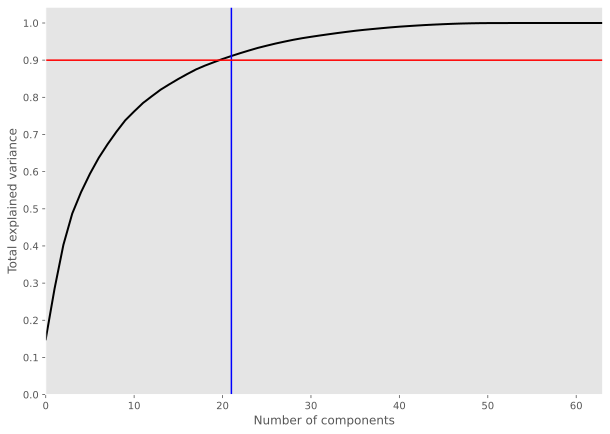

In [12]:
pca = decomposition.PCA().fit(X)

plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 63)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(21, c='b')
plt.axhline(0.9, c='r')
plt.show();

<a class="anchor" id="7.1.3"></a>

### <span style="color:blue; font-size:1.2em;">7.1.3. Метод головних компонент: іграшковий приклад</span>

[Повернутися до змісту](#7)

Далі розглянемо іграшковий приклад до якого застосуємо PCA. Нехай дано вибірку X:

In [13]:
X = np.array([[1., 3.],
              [3., 5.],
              [5., 1.],
              [7., 4.],
              [4., 7.]])

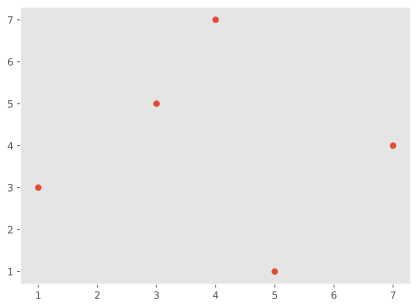

In [14]:
plt.scatter(X[:,0], X[:, 1]);

Як вибрати напрямок, у проєкції на який дисперсія координат точок є максимальною? Синя пряма чи зелена? А може, червона?

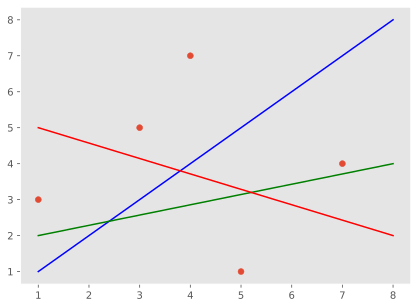

In [15]:
plt.scatter(X[:,0], X[:, 1])
plt.plot(np.linspace(1,8,10), np.linspace(1,8,10), color='b')
plt.plot(np.linspace(1,8,10), np.linspace(2,4,10), color='g')
plt.plot(np.linspace(1,8,10), np.linspace(5,2,10), color='r')

Стандартизуємо матрицю X. Приберемо середні стовпці (4 і 4) і поділимо на стандартні відхилення за стовпцями (2 і 2).

In [16]:
from sklearn.preprocessing import StandardScaler

In [17]:
X_scaled = StandardScaler().fit_transform(X)
X_scaled

array([[-1.5, -0.5],
       [-0.5,  0.5],
       [ 0.5, -1.5],
       [ 1.5,  0. ],
       [ 0. ,  1.5]])

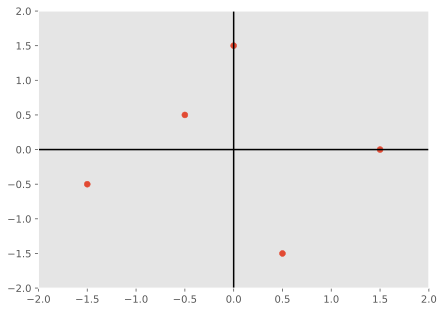

In [18]:
plt.scatter(X_scaled[:, 0], X_scaled[:, 1])
plt.plot([-2,2],[0,0], c='black')
plt.plot([0,0],[-2,2], c='black')
plt.xlim(-2,2)
plt.ylim(-2,2);

Позначимо нові координати (стобці матриці X_scaled) $x_1$ і $x_2$.

Розглянемо задачу: знайти таку лінійну комбінацію $z = \alpha x_1 + \beta x_2$, що досягається максимальне значення дисперсії $z$. Водночас має виконуватись умова $\alpha^2 + \beta^2 = 1.$

Зауважимо що

$$\Large D[z] = E[(z - E[z])^2]  = E[z^2] = \frac{1}{n} \sum_i^n z_i^2,$$

оскільки $E[z] = \alpha E[x_1] + \beta E[x_2] = 0$ (нові координати центровані).

Тоді задача формується так:

$$\large \begin{cases} \max_{\alpha, \beta} \sum_i^n (\alpha x_{1_i} + \beta x_{2_i})^2; \\  \alpha^2 + \beta^2 = 1.\end{cases}$$

Маємо $2z = [-3\alpha -\beta,\ -\alpha +\beta,\ \alpha -3\beta,\ 3\alpha,\ 3\beta]^T$. Для задачі максимізації неважливо, що ми помножили на 2, зате так зручніше.

Розпишемо у нашому випадку:

$\large \sum_i^n (\alpha x_{1_i} + \beta x_{2_i})^2 = (-3\alpha -\beta)^2 + ( -\alpha +\beta)^2 +( \alpha -3\beta)^2 +( 3\alpha)^2 +( 3\beta)^2 = $

$= 20\alpha^2 - 2\alpha\beta + 20\beta^2$ = <font color='green'>\\ оскільки $\alpha^2 + \beta^2 = 1$ \\ </font>  = $\large 20 - 2\alpha\beta.$

Залишилося лише мінімізувати $\alpha\beta$. Це можна робити методом Лагранжа, але тут можна простіше:

$$\large \begin{cases} \min_{\alpha, \beta} \alpha\beta; \\  \alpha^2 + \beta^2 = 1.\end{cases}$$

$\large \alpha\beta = \beta^2(\frac{\alpha}{\beta})$ = <font color='green'>\\ заміна t = $\frac{\alpha}{\beta}, \alpha^2 + \beta^2 = 1$ \\  </font> = $\large \frac{t}{1+t^2}.$

Шукаємо мінімум функції однієї змінної, знаходимо, що $t^* = -1$.

Тому,

$$\large \begin{cases} \alpha^* = -\beta^*;\\  (\alpha^*)^2 + (\beta^*)^2 = 1.\end{cases} \Rightarrow \alpha^* = 
\frac{1}{\sqrt{2}}, \beta^* = - \frac{1}{\sqrt{2}}.$$

Отже,

$$\large z = \frac{1}{\sqrt{2}} x_1 - \frac{1}{\sqrt{2}}x_2. $$

Тобто вісь $z$ повернена на 45 градусів щодо $x_1$ та $x_2$ і "спрямована на південний схід".

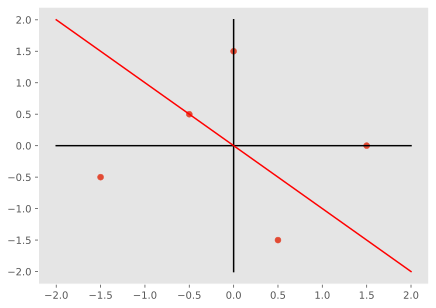

In [19]:
plt.scatter(X_scaled[:, 0], X_scaled[:, 1])
plt.plot([-2,2],[0,0], c='black')
plt.plot([0,0],[-2,2], c='black')
plt.plot([-2,2],[2,-2], c='red');

Нові координати точок за віссю z:

In [20]:
X_scaled.dot(np.array([1./np.sqrt(2), -1./np.sqrt(2)]))

array([-0.70710678, -0.70710678,  1.41421356,  1.06066017, -1.06066017])

#### Сингулярне розкладання матриці X (Singular value decomposition, SVD)

Подання буде таким: $X = U\Sigma V^T$.

- Матриця $U$ складена із власних векторів матриці $XX^T$. Це ліві сингулярні вектори матриці $X$;
- Матриця $V$ складена із власних векторів матриці $X^TX$. Це праві сингулярні вектори матриці $X$;
- Матриця $\Sigma$ – діагональна (поза головною діагоналлю – нулі), і на діагоналі розташовані корені із власних значень матриці $X^TX$ (або $XX^T$). Це [сингулярні числа](https://uk.wikipedia.org/wiki/%D0%A1%D0%B8%D0%BD%D0%B3%D1%83%D0%BB%D1%8F%D1%80%D0%BD%D0%B5_%D0%B7%D0%BD%D0%B0%D1%87%D0%B5%D0%BD%D0%BD%D1%8F) матриці $X$.

Добуток $XX^T$ подано так:

In [21]:
X_scaled.dot(X_scaled.T)

array([[ 2.5 ,  0.5 ,  0.  , -2.25, -0.75],
       [ 0.5 ,  0.5 , -1.  , -0.75,  0.75],
       [ 0.  , -1.  ,  2.5 ,  0.75, -2.25],
       [-2.25, -0.75,  0.75,  2.25,  0.  ],
       [-0.75,  0.75, -2.25,  0.  ,  2.25]])

Дбуток $X^TX$ подано так:

In [22]:
X_scaled.T.dot(X_scaled)

array([[ 5.  , -0.25],
       [-0.25,  5.  ]])

Власні вектори $XX^T$ (ліві сингулярні):

In [23]:
np.linalg.eig(X_scaled.dot(X_scaled.T))[1]

array([[-6.95492109e-01,  6.48885685e-01, -3.08606700e-01,
        -3.48304784e-01, -3.68484004e-01],
       [ 1.36936270e-01,  8.94189345e-16, -3.08606700e-01,
        -6.38721284e-01,  5.38313493e-01],
       [ 2.88286884e-02,  3.24442842e-01,  6.17213400e-01,
         1.61207215e-01,  5.87395649e-01],
       [-6.59456248e-01, -4.86664263e-01,  4.62910050e-01,
        -6.14947617e-01, -3.84844723e-01],
       [-2.48647438e-01, -4.86664263e-01, -4.62910050e-01,
         2.58012715e-01,  2.85129816e-01]])

Власні вектори $X^TX$ (праві сингулярні). Ці вектори задають подання головних компонент через початкові координати (тобто задають поворот).

In [24]:
np.linalg.eig(X_scaled.T.dot(X_scaled))[1]

array([[ 0.70710678,  0.70710678],
       [-0.70710678,  0.70710678]])

Бачимо, що головні компоненти:

$$\Large z_1 = \frac{1}{\sqrt{2}} x_1 - \frac{1}{\sqrt{2}}x_2,\ z_2 = \frac{1}{\sqrt{2}} x_1 + \frac{1}{\sqrt{2}}x_2. $$

Власні значення $X^TX$ (сингулярні числа):

In [25]:
np.linalg.eig(X_scaled.T.dot(X_scaled))[0]

array([5.25, 4.75])

In [26]:
np.linalg.eig(X_scaled.dot(X_scaled.T))[0]

array([ 0.00000000e+00,  4.75000000e+00,  5.25000000e+00,  1.29949617e-16,
       -1.94260448e-16])

In [27]:
from scipy.linalg import svd
U, Sigma, VT = svd(X_scaled)

Дійсно, на діагоналі матриці $\Sigma$ розташовані корені із власних значень $X^TX$ ($\sqrt{5.25} \approx 2.29, \sqrt{4.75} \approx 2.18$):

In [28]:
Sigma

array([2.29128785, 2.17944947])

Вектор матриці $VT$ (праві сингулярні вектори для початкової матриці) задають поворот. Тобто перша головна компонента "спрямована на південний схід", друга – на південний захід.

In [29]:
VT

array([[ 0.70710678, -0.70710678],
       [-0.70710678, -0.70710678]])

Подання даних у проєкції на 2 основні компоненти $Z = XV$:

In [30]:
X_scaled.dot(VT.T)

array([[-7.07106781e-01,  1.41421356e+00],
       [-7.07106781e-01,  1.16573418e-15],
       [ 1.41421356e+00,  7.07106781e-01],
       [ 1.06066017e+00, -1.06066017e+00],
       [-1.06066017e+00, -1.06066017e+00]])

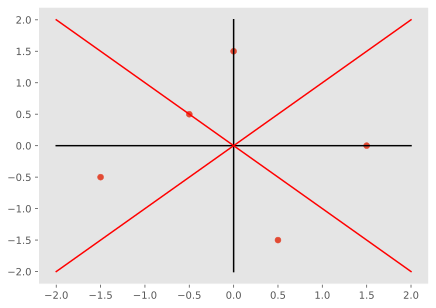

In [31]:
plt.scatter(X_scaled[:, 0], X_scaled[:, 1])
plt.plot([-2,2],[0,0], c='black')
plt.plot([0,0],[-2,2], c='black')
plt.plot([-2,2],[2,-2], c='red')
plt.plot([-2,2],[-2,2], c='red');

Тут [SVD SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.svd.html) "направив" вісь z1 вправо та вниз, а вісь z2 – вліво та вниз. Можна перевірити, що отримане подання є істинним.

<a class="anchor" id="7.2"></a>

## <span style="color:blue; font-size:1.2em;">7.2. Методи кластерного аналізу</span>

[Повернутися до змісту](#7)

Інтуїтивна постановка задача кластеризації досить проста, наприклад, ми можемо сказати: "Ось тут ми маємо насипані точки. Ми бачимо, що вони звалюються в якісь купки разом. Було би добре мати можливість ці точки відносити до купок і за появи нової точки на площині говорити, в яку купку вона падає." З такої постановки задачі бачимо, що простору для фантазії виходить багато, і від цього виникає безліч алгоритмів розв'язання цієї задачі.

Нижче зобразимо основні [алгоритми](https://scikit-learn.org/stable/modules/clustering.html) кластеризації з документації пакету scikit-learn.

<figure>
<img src="https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/main/03_img/7_2_clustering-scikit-learn.png" alt="Trulli" style="width:100%">
<figcaption align = "center"><i>Приклади роботи алгоритмів кластеризації із документації пакету scikit-learn</i></figcaption>
</figure>

<a class="anchor" id="7.2.1"></a>

### <span style="color:blue; font-size:1.2em;">7.2.1. $k$-середніх</span>

[Повернутися до змісту](#7)

Алгоритм $k$-середніх є, напевно, найпопулярнішим та найпростішим алгоритмом кластеризації. $k$-середніх дуже легко подається у вигляді простого псевдокоду:
1. Вибрати кількість кластерів $k$, яка видається оптимальною для наших даних.
2. Висипати випадково в простір наших даних точки кількістю $k$ (центроїди).
3. Для кожної точки набору даних обрахувати, до якого центроїду вона розташована найближче.
4. Перенести кожен центроїд до центру вибірки, яку ми віднесли до цього центроїду.
5. Повторювати останні два кроки наперед задану кількість разів, або до тих пір, допоки центроїди не "зійдуться" (зазвичай це означає, що їхнє зміщення щодо попереднього положення не перевищує якогось заздалегідь заданого невеликого значення).

У разі звичайної евклідової метрики для точок, що лежать на площині, цей алгоритм дуже просто розписується аналітично і зображення на 2D площині. Нижче розглянемо відповідний приклад:

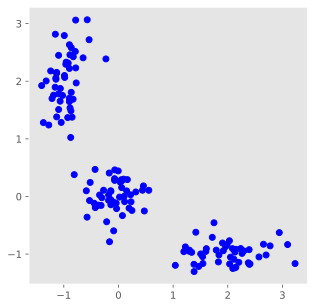

In [32]:
# Почнемо з того, що насипаємо на площину три кластери крапок
X = np.zeros((150, 2))

np.random.seed(seed=42)
X[:50, 0] = np.random.normal(loc=0.0, scale=.3, size=50)
X[:50, 1] = np.random.normal(loc=0.0, scale=.3, size=50)

X[50:100, 0] = np.random.normal(loc=2.0, scale=.5, size=50)
X[50:100, 1] = np.random.normal(loc=-1.0, scale=.2, size=50)

X[100:150, 0] = np.random.normal(loc=-1.0, scale=.2, size=50)
X[100:150, 1] = np.random.normal(loc=2.0, scale=.5, size=50)

plt.figure(figsize=(5, 5))
plt.plot(X[:, 0], X[:, 1], 'bo');

In [33]:
# В бібліотеці SciPy є чудова функція, яка обраховує відстані
# між парами точок з двох масивів, що подаються їй на вхід
from scipy.spatial.distance import cdist

# Застосуємо рандомізоване розбиття до вхідних даних
# та насипаємо для початку три випадкові центроїди
np.random.seed(seed=42)
centroids = np.random.normal(loc=0.0, scale=1., size=6)
centroids = centroids.reshape((3, 2))

cent_history = []
cent_history.append(centroids)

for i in range(3):
    # Обраховуємо відстані від спостережень до центроїд
    distances = cdist(X, centroids)
    # Смотрим, до какой центроиде каждой точке ближе всего
    # Отримуємо найкоротші відстані від кожної точки до центроїд
    labels = distances.argmin(axis=1)
    
    # Запишемо в кожну нову центроїду геометричний центр її точок
    centroids = centroids.copy()
    centroids[0, :] = np.mean(X[labels == 0, :], axis=0)
    centroids[1, :] = np.mean(X[labels == 1, :], axis=0)
    centroids[2, :] = np.mean(X[labels == 2, :], axis=0)
    
    cent_history.append(centroids)

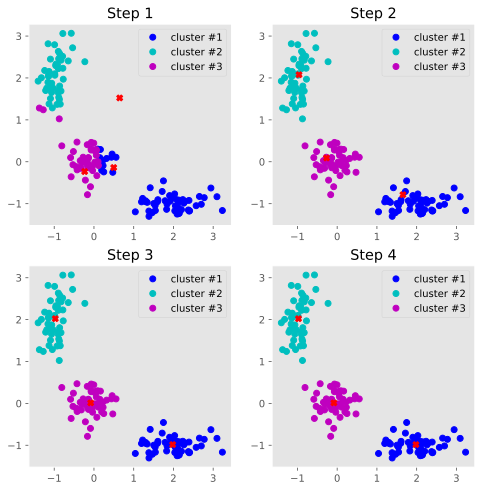

In [34]:
# Насамкінець, зобразимо всю цю красу на графіку
plt.figure(figsize=(8, 8))
for i in range(4):
    distances = cdist(X, cent_history[i])
    labels = distances.argmin(axis=1)
    
    plt.subplot(2, 2, i + 1)
    plt.plot(X[labels == 0, 0], X[labels == 0, 1], 'bo', label='cluster #1')
    plt.plot(X[labels == 1, 0], X[labels == 1, 1], 'co', label='cluster #2')
    plt.plot(X[labels == 2, 0], X[labels == 2, 1], 'mo', label='cluster #3')
    plt.plot(cent_history[i][:, 0], cent_history[i][:, 1], 'rX')
    plt.legend(loc=0)
    plt.title('Step {:}'.format(i + 1));

Також варто зауважити, що хоч ми й розглянули вище евклідову відстань, алгоритм буде збігатися і у разі будь-якої іншої метрики. Тому для різних задач кластеризації залежно від даних має сенс експериментувати не лише з кількістю кроків або критерієм збіжності, але й з метрикою, за якою ми обраховуємо відстані між точками та центроїдами кластерів.

Іншою особливістю цього алгоритму є те, що він чутливий до початкового положення центроїд кластерів у просторі. В таких випадків допомогає запуск кількох ітерацій алгоритму із подальшим усередненням отриманих кластерів.

#### Вибір кількості кластерів для $k$-середніх

На відміну від задач класифікації або регресії, у разі кластеризації складніше вибрати критерій, за допомогою якого було б просто подати задачу кластеризації як задачу оптимізації. У випадку $k$-середніх поширеним є такий критерій – сума квадратів відстаней від точок до центроїдів кластерів, до яких вони відносяться.

$$\large J(C) = \sum_{k=1}^K\sum_{i~\in~C_k} ||x_i - \mu_k|| \rightarrow \min\limits_C,$$

де $C$ – множина кластерів потужності $K$, $\mu_k$ – центроїд кластера $C_k$.

Зрозуміло, що здоровий глузд у цьому є: ми хочемо, щоб точки розташовувалися кучно біля центрів своїх кластерів. Але тут незадача: мінімум такого фнукціонала буде досягатися тоді, коли кластерів стільки ж, скільки і точок (тобто кожна точка – це кластер з одного елемента).
Для вирішення цього питання (вибору кількості кластерів) часто користуються такою евристикою: вибирають ту кількість кластерів, починаючи з якої описаний функціонал $J(C)$ падає "вже не так швидко". Або більш формально:

$$\large D(k) = \frac{|J(C_k) - J(C_{k+1})|}{|J(C_{k-1}) - J(C_k)|}  \rightarrow \min\limits_k. $$

Нижче розглянемо приклад $k$-середніх.

In [35]:
#from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

In [36]:
inertia = []
for k in range(1, 8):
    kmeans = MiniBatchKMeans(n_clusters=k, batch_size=4096, random_state=1).fit(X)
    inertia.append(np.sqrt(kmeans.inertia_))

C:\Users\radiu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1836: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(
C:\Users\radiu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1836: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(
C:\Users\radiu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1836: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(
C:\User

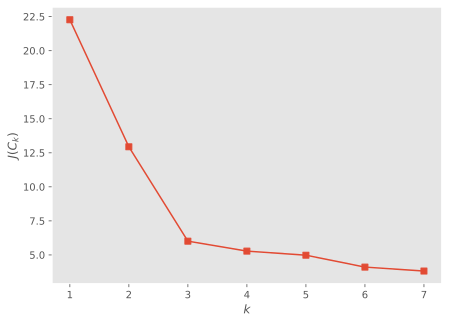

In [37]:
plt.plot(range(1, 8), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

Бачимо, що $J(C_k)$ сильно падає зі збільшенням кількості кластерів з 1 до 2 і з 2 до 3 і вже не так сильно – під час зміни $k$ з 3 до 4. Отже, в цій задачі оптимально задати 3 кластери.

#### Можливі проблеми

Розв'язання задачі *k*-середніх є NP-складним ([The planar $k$-means problem is NP-hard](https://core.ac.uk/download/pdf/82786926.pdf)), і для розмірності $d$, кількості кластерів $k$ і кількості точок $n$ обраховується за $O(n^{d k+1})$. Для усунення такого болю часто використовують евристики, наприклад MiniBatch *k*-means, який для навчання використовує не весь набір даних загалом, а лише маленькі його частини (так звані, batches) й оновлює центроїди, використовуючи середнє за всю історію оновлень центроїду від усіх точок, що відносяться до нього. Порівняння звичайного *k*-середніх та його MiniBatch версії можна переглянути в [документації scikit-learn](http://scikit-learn.org/stable/auto_examples/cluster/plot_mini_batch_kmeans.html).

[Реалізація](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) алгоритму в scikit-learn має багато корисних параметрів, наприклад, можливість задати кількість запусків через параметр `n_init`, що дасть стійкіші центроїди для кластерів у разі зміщених даних. До того ж, ці запуски можна робити паралельно, не витрачаючи додатковий час на обрахування.

<a class="anchor" id="7.2.2"></a>

### <span style="color:blue; font-size:1.2em;">7.2.2. Поширення спорідненості</span>

[Повернутися до змісту](#7)

Поширення спорідненості (з англ. [Affinity Propagation](https://en.wikipedia.org/wiki/Affinity_propagation), AffProp) – ще один приклад алгоритму кластеризації. На відміну від алгоритму $k$-середніх, цей підхід не вимагає заздалегідь визначати кількість кластерів, на яку ми хочемо розбити наші дані. Основна ідея алгоритму полягає кластеризуванні у відокремлені групи на основі того, як вони "взаємодіють" між собою або наскільки вони споріденні між собою (схожі один на одного).

Введемо метрику "спорідненості", що визначається тим, що $s(x_i, x_j) > s(x_i, x_k)$, якщо спостереження $x_i$ більш споріднене з спостереженням $x_j$, ніж $x_k$. Простим прикладом такої спорідненості буде негативний квадрат відстані $s(x_i, x_j) = - ||x_i - x_j||^{2}$.

Далі опишемо сам процес "взаємодії". Для цього введемо дві матриці, що ініціалізуються нулями. Перша матриця $R = \{r_{i,k} \}$ буде описувати наскільки добре $k$-те спостереження підходить для того, щоб бути "прикладом для наслідування" для $i$-того спостереження щодо всіх інших потенційних "прикладів", а друга - $A = \{a_{i,k} \}$ описуватиме наскільки правильним було б для $i$-того спостереження вибрати $k$-те як такий "приклад" . Звучить трохи заплутано, але далі в лекції ми розглянемо приклад для кращого розуміння цього алгоритму.

Після цього матриці оновлюються по черзі за правилами:

$$\large r_{i,k} \leftarrow s_(x_i, x_k) - \max_{k' \neq k} \left\{ a_{i,k'} + s(x_i, x_k') \right\},$$

$$\large a_{i,k} \leftarrow \min \left( 0, r_{k,k} + \sum_{i' \not\in \{i,k\}} \max(0, r_{i',k}) \right), \ \ \  i \neq k,$$

$$\large a_{k,k} \leftarrow \sum_{i' \neq k} \max(0, r_{i',k}).$$

#### Спектральна кластеризація

Спектральна кластеризація (з англ. [Spectral Clustering](https://en.wikipedia.org/wiki/Spectral_clustering), SpecClus) поєднує кілька описаних вище підходів, щоб отримати якнайбільше користі від складних перетворень розмірності меншої за початковий простір.

Для цього алгоритму нам потрібно визначити матрицю схожості спостережень (adjacency matrix). Можна це зробити так, як і для Affinity Propagation вище:

$$ \large A_{i, j} = - ||x_i - x_j||^{2}. $$

Ця матриця також описує повний граф з вершинами у наших спостереженнях та ребрами між кожною парою спостережень. Ваги ребер відповідають ступеню схожості вершин графу. Для вище обраної метрики та точок, що лежать на площині, ця матриця буде інтуїтивною та простою — дві точки схожі, якщо ребро між ними коротше. Тепер нам потрібно розділити отриманий граф на дві частини так, щоб точки у двох графах були загалом більше схожі на інші точки всередині "своєї" половини графа, ніж на точки в "іншій" половині. Формальна назва такої задачі – [Normalized cuts problem](https://www.cs.yale.edu/homes/vishnoi/Publications_files/MVMCVPR11.pdf).

<a class="anchor" id="7.2.3"></a>

### <span style="color:blue; font-size:1.2em;">7.2.3. Ієрархічна кластеризація</span>

[Повернутися до змісту](#7)

Ієрархічна кластеризація (з англ. [Hierarchical Clustering](https://en.wikipedia.org/wiki/Hierarchical_clustering), HierClus) – певно найпростіший і найкраще зрозумілий алгоритм кластеризації без фіксованого числа кластерів. Ідея алгоритму дуже проста:

1. Починаємо з того, що висипаємо на кожну точку свій кластер.
2. Сортуємо попарні відстані між центрами кластерів за зростанням.
3. Беремо пару найближчих кластерів, склеюємо в один і перераховуємо центр кластера.
4. Повторюємо п. 2 і 3, поки всі дані не склеяться в один кластер.

Сам процес пошуку найближчих кластерів може відбуватися за допомогою різних методів об'єднання точок:
1. Single linkage – мінімум попарних відстаней між точками із двох кластерів:
$d(C_i, C_j) = min_{x_i \in C_i, x_j \in C_j} ||x_i - x_j||$.
2. Complete linkage – максимум попарних відстаней між точками із двох кластерів
$d(C_i, C_j) = max_{x_i \in C_i, x_j \in C_j} ||x_i - x_j||$.
3. Average linkage – середня попарна відстань між точками з двох кластерів
$d(C_i, C_j) = \frac{1}{n_i n_j} \sum_{x_i \in C_i} \sum_{x_j \in C_j} ||x_i - x_j||$.
4. Centroid linkage – відстань між центроїдами двох кластерів
$d(C_i, C_j) = ||\mu_i - \mu_j||$.

Перевагою перших трьох підходів проти четвертого є те, що для них не потрібно перераховувати відстані щоразу після склеювання, що сильно знижує обчислювальну складність алгоритму.

За підсумками виконання такого алгоритму можна побудувати чудове дерево склеювання кластерів і дивлячись на нього визначити, на якому етапі нам було б оптимально зупинити алгоритм (або скористатися тим самим правилом ліктя, що у $k$-середніх).

На щастя для нас мова програмування Python передбачає використання вбудованих інструментів для побудови таких дендрограм для ієрархічної кластеризації. Розглянемо на прикладі наших кластерів із $k$-середніх:

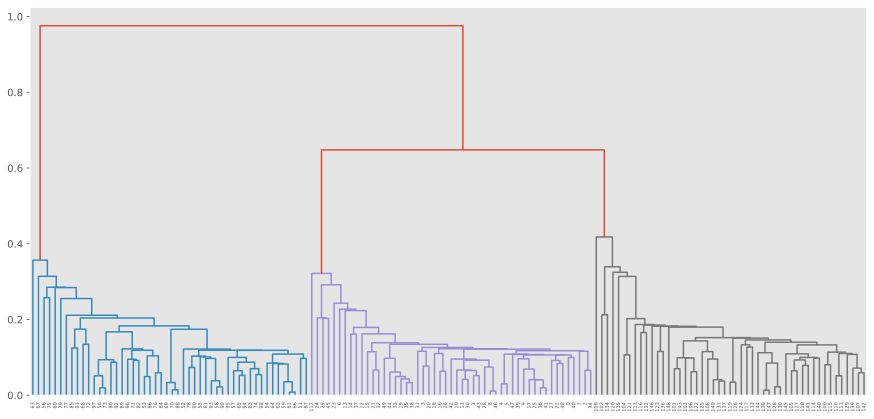

In [38]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

X = np.zeros((150, 2))

np.random.seed(seed=42)
X[:50, 0] = np.random.normal(loc=0.0, scale=.3, size=50)
X[:50, 1] = np.random.normal(loc=0.0, scale=.3, size=50)

X[50:100, 0] = np.random.normal(loc=2.0, scale=.5, size=50)
X[50:100, 1] = np.random.normal(loc=-1.0, scale=.2, size=50)

X[100:150, 0] = np.random.normal(loc=-1.0, scale=.2, size=50)
X[100:150, 1] = np.random.normal(loc=2.0, scale=.5, size=50)

distance_mat = pdist(X) # pdist порахує нам верхній трикутник матриці попарних відстаней

Z = hierarchy.linkage(distance_mat, 'single') # linkage — реалізація ієрархічного алгоритму
plt.figure(figsize=(15, 7))
dn = hierarchy.dendrogram(Z, color_threshold=0.5)

<a class="anchor" id="7.2.4"></a>

### <span style="color:blue; font-size:1.2em;">7.2.4. Метрики якості кластеризації</span>

[Повернутися до змісту](#7)

Завдання оцінювання якості кластеризації є складнішим проти оцінювання якості класифікації. По-перше, такі оцінки не мають залежати від значень міток (з англ. labels), лише від розбиття вибірки. По-друге, істинні мітки об'єктів не завжди відомі, тому також потрібні оцінки, що дають змогу оцінити якість кластеризації, використовуючи лише нерозмічену вибірку.

Виділяють *зовнішні* та *внутрішні* метрики якості. Зовнішні використовують інформацію про справжнє розбиття на кластери, тоді як внутрішні метрики не використовують жодної зовнішньої інформації та оцінюють якість кластеризації, ґрунтуючись лише на наборі даних. Оптимальну кількість кластерів зазвичай визначають із використанням внутрішніх метрик.

Усі наведені нижче метрики реалізовані в `sklearn.metrics` ([покликання](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation)).

#### [Adjusted Rand Index](https://en.wikipedia.org/wiki/Rand_index#:~:text=The%20adjusted%20Rand%20index%20is,specified%20by%20a%20random%20model.) (ARI)

Передбачається, що істинні позначки об'єктів відомі. Ця метрика не залежить від значень міток, лише від розбиття вибірки на кластери. Нехай $N$ – кількість об'єктів у вибірці. Позначимо через $a$ – кількість пар об'єктів, що мають однакові мітки і що перебувають в одному кластері, через $b$ – кількість пар об'єктів, що мають різні мітки та перебувають у різних кластерах. Тоді Rand Index це

$$\large \text{RI} = \frac{2(a + b)}{n(n-1)}.$$

Тобто це частка об'єктів, для яких ці розбиття (початкове та отримане в результаті кластеризації) "узгоджені". Rand Index (RI) виражає схожість двох різних кластеризацій однієї і тієї ж вибірки. Щоб цей індекс давав значення близькі до нуля для випадкових кластеризацій за будь-якого $N$ та кількості кластерів, необхідно нормувати його. Так визначається Adjusted Rand Index:

$$\large \text{ARI} = \frac{\text{RI} - E[\text{RI}]}{\max(\text{RI}) - E[\text{RI}]}.$$

Ця метрика є симетричною, не залежить від значень та перестановок міток. Отже, цей індекс є відстанню між різними розбиттями вибірки. $\text{ARI}$ набуває значень у діапазоні $[-1, 1]$. Негативні значення відповідають "незалежним" розбиттям на кластери, значення, що близькі до нуля, – випадковим розбиттям, і позитивні значення вказують на те, що два розбиття схожі (збігаються за $\text{ARI} = 1$).

#### [Adjusted Mutual Information](https://en.wikipedia.org/wiki/Adjusted_mutual_information) (AMI)

Ця метрика є досить схожою на $\text{ARI}$. Вона також є симетричною, не залежить від значень та перестановок міток. AMI визначається з використанням функції [ентропії](https://en.wikipedia.org/wiki/Entropy_(information_theory), інтерпретуючи розбиття вибірки, як дискретні розподіли (ймовірність віднесення до кластера дорівнює частці об'єктів у ньому). Індекс $MI$ визначається як [взаємна інформація](https://en.wikipedia.org/wiki/Mutual_information) для двох розподілів, що відповідають розбиттям вибірки на кластери. Інтуїтивно, взаємна інформація вимірює частку інформації, що є спільною для обох розбиттів: наскільки інформація щодо одного з них зменшує невизначеність щодо іншого.

Аналогічно $\text{ARI}$ визначається індекс $\text{AMI}$, що дає змогу позбутися зростання індексу $\text{MI}$ зі збільшенням кількості класів. $\text{AMI}$ набуває значень у діапазоні $[0, 1]$. Значення, близькі до нуля, вказують на незалежність розбиття, а близькі до одиниці – на їхню схожість (збіжність за $\text{AMI} = 1$).

#### [Гомогенність, повнота, V-міра](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation)

Формально ці метрики також визначаються з використанням функцій ентропії та умовної ентропії, розглядаючи розбиття вибірки як дискретні розподіли:

$$\large h = 1 - \frac{H(C\mid K)}{H(C)}, c = 1 - \frac{H(K\mid C)}{H(K)},$$

де $K$ – результат кластеризації, $C$ – істинне розбиття вибірки на класи.

Отже, $h$ демонструє наскільки кожен кластер складається з об'єктів одного класу, а $c$ – наскільки об'єкти одного класу відносяться до одного кластера. Ці метрики є симетричними. Обидві величини набувають значень в діапазоні $[0, 1]$, і більші значення відповідають більш точній кластеризації. Також ці метрики не є нормалізованими як $\text{ARI}$ або $\text{AMI}$, і тому залежать від кількості кластерів. Випадкова кластеризація не даватиме нульові показники за великої кількості класів і малій кількості об'єктів. У цих випадках краще використовувати $\text{ARI}$. Проте, якщо кількість об'єктів перевищує 1000, а кількість кластерів менше 10, ця складність не так явно виражена і може бути проігнорована.

Для обліку обох величин $h$ і $c$ одночасно вводиться $V$-метрика, як їх середнє гармонійне:

$$\large v = 2\frac{hc}{h+c}.$$

Вона є симетричною та показує, наскільки дві кластеризації схожі між собою.

#### [Silhouette](https://en.wikipedia.org/wiki/Silhouette_(clustering)) (силует)

На відміну від описаних вище метрик, даний коефіцієнт передбачає знання істинних міток об'єктів, і дає змогу оцінити якість кластеризації, використовуючи тільки нерозмічену вибірку і результат кластеризації.

Спершу силует визначається окремо кожному об'єкту. Позначимо через $a$ – середню відстань від даного об'єкта до об'єктів із того ж кластера, через $b$ – середню відстань від даного об'єкта до об'єктів із найближчого кластера (не того, в якому перебуває розглядуваний об'єкт). Тоді силуетом даного об'єкта називається величина:

$$\large s = \frac{b - a}{\max(a, b)}.$$

Силуетом вибірки називається середня величина силуету об'єктів даної вибірки. Силует показує, наскільки середня відстань до об'єктів кластера відрізняється від середньої відстані до об'єктів інших кластерів. Ця величина лежить у діапазоні $[-1, 1]$. Значення, що близькі до -1, відповідають поганим (розрізненим) кластеризаціям, значення близькі до нуля вказують на перетин кластерів між собою, значення, близькі до 1, відповідають "щільним" чітко виділеним кластерам. Отже, чим більше значення силуету, тим чіткіше виділені кластери, тобто вони є компактними, щільно згрупованими хмарами точок.

За допомогою силуету також можна вибирати оптимальну кількість кластерів $k$ (якщо вона заздалегідь невідома): вибирається кількість кластерів, що максимізує значення силуету. На відміну від попередніх метрик, силует залежить від форми кластерів, і досягає великих значень для більш опуклих кластерів, що одержуються за допомогою алгоритмів, які ґрунтуються на відновленні щільності розподілу.

Наостанок розглянемо вище описані метрики для наших алгоритмів на прикладі рукописних цифр MNIST:

In [39]:
from sklearn import metrics
from sklearn import datasets
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, SpectralClustering


data = datasets.load_digits()
X, y = data.data, data.target

algorithms = []
algorithms.append(KMeans(n_clusters=10, random_state=1))
algorithms.append(AffinityPropagation(random_state=0))
algorithms.append(SpectralClustering(n_clusters=10, random_state=1,
                                     affinity='nearest_neighbors'))
algorithms.append(AgglomerativeClustering(n_clusters=10))

data = []
for algo in algorithms:
    algo.fit(X)
    data.append(({
        'ARI': metrics.adjusted_rand_score(y, algo.labels_),
        'AMI': metrics.adjusted_mutual_info_score(y, algo.labels_),
        'Homogenity': metrics.homogeneity_score(y, algo.labels_),
        'Completeness': metrics.completeness_score(y, algo.labels_),
        'V-measure': metrics.v_measure_score(y, algo.labels_),
        'Silhouette': metrics.silhouette_score(X, algo.labels_)}))

results = pd.DataFrame(data=data, columns=['ARI', 'AMI', 'Homogenity',
                                           'Completeness', 'V-measure', 
                                           'Silhouette'],
                       index=['k-means', 'AffProp', 
                              'SpecClus', 'HierClus'])

results

,ARI,AMI,Homogenity,Completeness,V-measure,Silhouette
k-means,0.662295,0.736567,0.735448,0.742972,0.739191,0.182097
AffProp,0.175174,0.612460,0.958907,0.486901,0.645857,0.115197
SpecClus,0.756461,0.852040,0.831691,0.876614,0.853562,0.182729
HierClus,0.794003,0.866832,0.857513,0.879096,0.868170,0.178497


Бачимо, що для цієї задачі кластеризації рукописних цифр MNIST найкращі результати демонструє метод ієрархічної кластеризації (HierClus).

<a class="anchor" id="7.3"></a>

## <span style="color:blue; font-size:1.2em;">7.3. Корисні посилання</span>

[Повернутися до змісту](#7)

- [Кластерний аналіз](https://uk.wikipedia.org/wiki/%D0%9A%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%BD%D0%B8%D0%B9_%D0%B0%D0%BD%D0%B0%D0%BB%D1%96%D0%B7) в україномовній Вікіпедії [UKR].
- [Метод кластеризації на основі послідовного запуску *k*-середніх](https://praci.vntu.edu.ua/index.php/praci/article/view/323/321) [UKR].
- [Методи кластерного аналізу. Класифікація без навчання](http://ebooks.git-elt.hneu.edu.ua/babap/4-id4.html) – Онлайн-підручник [UKR].
- [Обзор](http://scikit-learn.org/stable/modules/clustering.html) методів кластеризації у пакеті scikit-learn [ENG].
- [Обзор](http://scikit-learn.org/stable/modules/clustering.html) оцінок ефективності кластеризації у пакеті scikit-learn [ENG].
- [Q&A](http://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues) Розбір PCA з прикладами [ENG].
- [Обзор зовнішніх та внутрішніх метрик якості кластеризації](https://en.wikipedia.org/wiki/Cluster_analysis#Evaluation_and_assessment) [ENG].
- [The Ultimate Guide to 12 Dimensionality Reduction Techniques (with Python codes)](https://www.analyticsvidhya.com/blog/2018/08/dimensionality-reduction-techniques-python/) [ENG].